<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

def sigmoid(x, a=1, b=1, c=1):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """
  
  return b * (1-1/(1+np.exp(c * (x - a))))

In [0]:
# This data begins at February 2, 2020 and is collected from Johns Hopkins
# University's live Coronavirus map.
# https://coronavirus.jhu.edu/map.html

cases_china = np.array([
  17.2e3,   # 2020-02-02
  19.7e3,   # 2020-02-03
  23.7e3,   # 2020-02-04
  27.4e3,   # 2020-02-05
  30.6e3,   # 2020-02-06
  34.1e3,   # 2020-02-07
  36.8e3,   # 2020-02-08
  39.8e3,   # 2020-02-09
  42.3e3,   # 2020-02-10
  44.3e3,   # 2020-02-11
  44.7e3,   # 2020-02-12
  59.8e3,   # 2020-02-13
  66.3e3,   # 2020-02-14
  68.3e3,   # 2020-02-15
  70.4e3,   # 2020-02-16
  72.4e3,   # 2020-02-17
  74.1e3,   # 2020-02-18
  74.5e3,   # 2020-02-19
  75.0e3,   # 2020-02-20
  75.5e3,   # 2020-02-21
  76.9e3,   # 2020-02-22
  76.9e3,   # 2020-02-23
  77.2e3,   # 2020-02-24
  77.7e3,   # 2020-02-25
  78.1e3,   # 2020-02-26
  78.5e3,   # 2020-02-27
  78.8e3,   # 2020-02-28
  79.3e3,   # 2020-02-29
  79.8e3,   # 2020-03-01
  80.0e3,   # 2020-03-02
  80.2e3,   # 2020-03-03
  80.3e3,   # 2020-03-04
  80.4e3,   # 2020-03-05
  80.6e3,   # 2020-03-06
  80.7e3,   # 2020-03-07
  80.7e3,   # 2020-03-08
  80.7e3,   # 2020-03-09
  80.8e3,   # 2020-03-10
  80.9e3,   # 2020-03-11
  80.9e3,   # 2020-03-12
  80.9e3,   # 2020-03-13
  81.0e3,   # 2020-03-14
  81.0e3,   # 2020-03-15
  81.0e3,   # 2020-03-16
])

cases_not_china = np.array([
  18.3e1,   # 2020-02-02
  18.8e1,   # 2020-02-03
  21.2e1,   # 2020-02-04
  22.7e1,   # 2020-02-05
  26.5e1,   # 2020-02-06
  31.7e1,   # 2020-02-07
  34.3e1,   # 2020-02-08
  36.1e1,   # 2020-02-09
  45.7e1,   # 2020-02-10
  47.6e1,   # 2020-02-11
  52.3e1,   # 2020-02-12
  53.8e1,   # 2020-02-13
  59.5e1,   # 2020-02-14
  68.5e1,   # 2020-02-15
  78.0e1,   # 2020-02-16
  89.6e1,   # 2020-02-17
  10.0e2,   # 2020-02-18
  11.0e2,   # 2020-02-19
  12.0e2,   # 2020-02-20
  14.0e2,   # 2020-02-21
  17.0e2,   # 2020-02-22
  20.0e2,   # 2020-02-23
  24.0e2,   # 2020-02-24
  28.0e2,   # 2020-02-25
  33.0e2,   # 2020-02-26
  43.0e2,   # 2020-02-27
  53.0e2,   # 2020-02-28
  68.0e2,   # 2020-02-29
  85.0e2,   # 2020-03-01
  10.3e3,   # 2020-03-02
  12.7e3,   # 2020-03-03
  14.9e3,   # 2020-03-04
  17.5e3,   # 2020-03-05
  21.2e3,   # 2020-03-06
  25.2e3,   # 2020-03-07
  29.1e3,   # 2020-03-08
  32.8e3,   # 2020-03-09
  37.8e3,   # 2020-03-10
  44.9e3,   # 2020-03-11
  47.4e3,   # 2020-03-12
  63.6e3,   # 2020-03-13
  75.1e3,   # 2020-03-14
  81.7e3,   # 2020-03-15
  10.1e4,   # 2020-03-16
])

In [0]:
from matplotlib import pyplot as plt

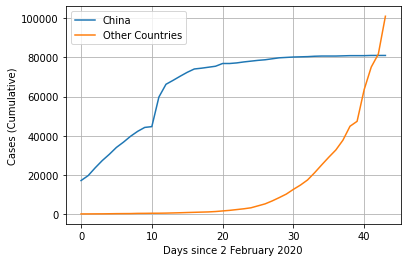

In [85]:
plt.plot(cases_china, label="China")
plt.plot(cases_not_china, label="Other Countries")

plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Cases (Cumulative)")
plt.legend()

plt.show()

In [0]:
from scipy.optimize import curve_fit

# Calculate curve fit for cases *inside* China.
initial_guesses = [0, 8e4, 0]
popt_ic, pcov_ic = curve_fit(sigmoid, *zip(*enumerate(cases_china)), p0=initial_guesses)
curve_china = lambda x: sigmoid(x, *popt_ic)

# Calculate curve fit for cases *outside* of China.
initial_guesses = [0, 0, 0]
popt_oc, pcov_oc = curve_fit(sigmoid, *zip(*enumerate(cases_not_china)), p0=initial_guesses)
curve_not_china = lambda x: sigmoid(x, *popt_oc)

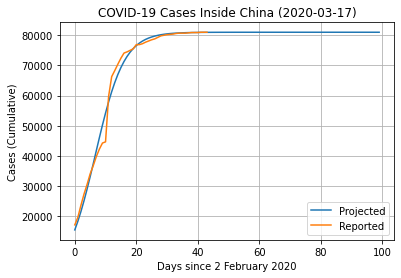

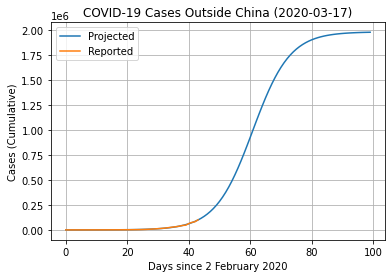

In [87]:
from datetime import date

# Prediction for inside China.
plt.plot([curve_china(x) for x in range(100)], label="Projected")
plt.plot(cases_china, label="Reported")

plt.title(f"COVID-19 Cases Inside China ({date.today()})")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Cases (Cumulative)")
plt.legend()

plt.show()

# Prediction for outside China.
plt.plot([curve_not_china(x) for x in range(100)], label="Projected")
plt.plot(cases_not_china, label="Reported")

plt.title(f"COVID-19 Cases Outside China ({date.today()})")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Cases (Cumulative)")
plt.legend()

plt.show()

# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def max_daily_growth_rate(a, b, c):
  sigma = sigmoid(a, a, b, c)

  sigma_x = c/b * sigma * (b - sigma)

  return int(sigma_x)

In [89]:
from datetime import datetime, timedelta

# Parameters for curve projecting cases inside China.
ic = {
    "a": popt_ic[0],
    "b": popt_ic[1],
    "c": popt_ic[2],
}

# Parameters for curve projecting cases outside China.
oc = {
    "a": popt_oc[0],
    "b": popt_oc[1],
    "c": popt_oc[2],
}

day_zero = datetime(2020, 2, 2, 0, 0)

max_growth_date_ic = day_zero + timedelta(days=int(ic["a"]))
max_growth_date_oc = day_zero + timedelta(days=int(oc["a"]))

print(f"""
Maximum Projected Growth Rate:
  - {max_daily_growth_rate(*popt_ic)} new cases inside China on {max_growth_date_ic.strftime("%-d %B %Y")}.
  - {max_daily_growth_rate(*popt_oc)} new cases outside China on {max_growth_date_oc.strftime("%-d %B %Y")}.
""".strip("\n"))

Maximum Projected Growth Rate:
  - 4345 new cases inside China on 8 February 2020.
  - 81866 new cases outside China on 2 April 2020.


In [90]:
import math

print(f"""
Total Projected Cases:
  - {math.floor(ic['b'])} inside China.
  - {math.floor(oc['b'])} outside China.
""".strip("\n"))

Total Projected Cases:
  - 81000 inside China.
  - 1980274 outside China.


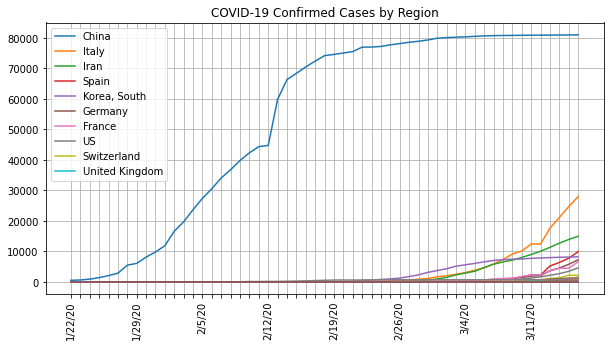

In [107]:
import pandas as pd


ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_only_confirmed_df)[-1], ascending=False)


plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title("COVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

i = 0
for region in ts_only_confirmed_df.index:
  ax.plot(ts_only_confirmed_df.loc[region], label=(region if i < legend_size else None))
  i += 1

ax.legend()

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

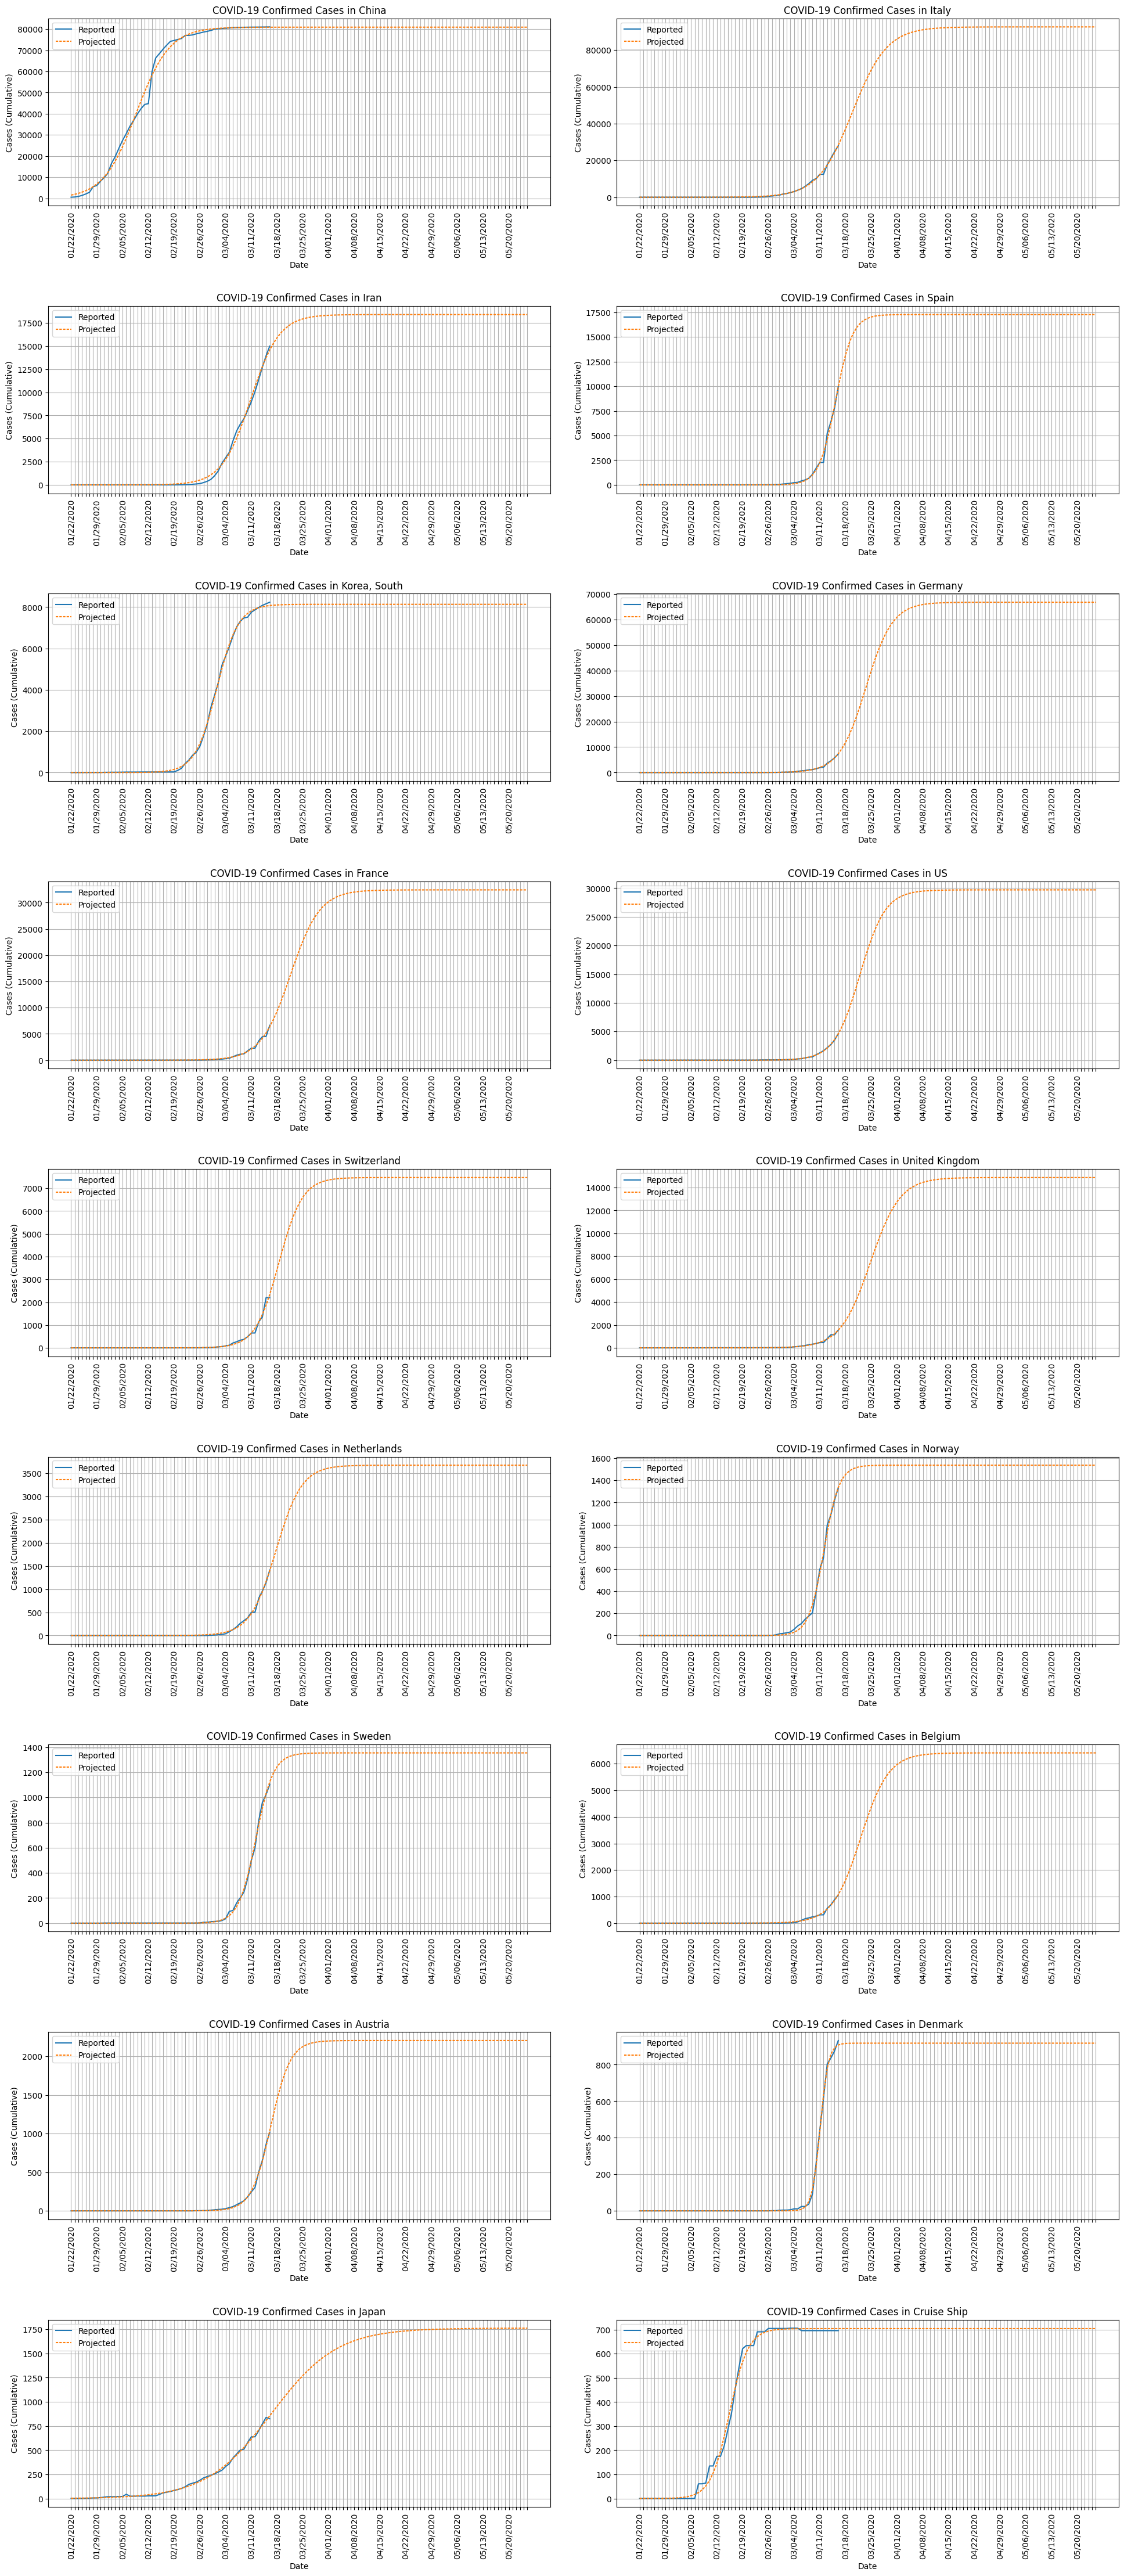

In [177]:
columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:18]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  current_ax.set_title(f"COVID-19 Confirmed Cases in {region}")
  current_ax.set_ylabel("Cases (Cumulative)")
  current_ax.set_xlabel("Date")



  regional_ts = ts_plot_df.loc[region]
  current_ax.plot(regional_ts, label="Reported")

  initial_guesses = [0, regional_ts.max(), 0]
  while True:
    try:
      popt, pcov = curve_fit(sigmoid, *zip(*enumerate(regional_ts)), p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[1] = (initial_guesses[1] + 1) * 1.5
  curve = lambda x: sigmoid(x, *popt)

  days_to_plot = 125

  current_ax.plot([curve(x) for x in range(days_to_plot)], label="Projected", dashes=[2, 1])

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)




  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()